In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
X_train = pd.read_csv('data/processed/X_train.csv', index_col=0)
X_test = pd.read_csv('data/processed/X_test.csv', index_col=0)
y_train = pd.read_csv('data/processed/y_train.csv', index_col=0)
y_test = pd.read_csv('data/processed/y_test.csv', index_col=0)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55025 entries, 2905 to 78034
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          55025 non-null  float64
 1   UGDS               55025 non-null  float64
 2   TUITFTE            55025 non-null  float64
 3   INEXPFTE           55025 non-null  float64
 4   PFTFAC             55025 non-null  float64
 5   UG25abv            55025 non-null  float64
 6   COMP_ORIG_YR4_RT   55025 non-null  float64
 7   WDRAW_ORIG_YR4_RT  55025 non-null  float64
 8   ENRL_ORIG_YR4_RT   55025 non-null  float64
 9   DEBT_MDN           55025 non-null  float64
 10  Year               55025 non-null  float64
 11  Cost               55025 non-null  float64
 12  Complete           55025 non-null  float64
 13  RetentionFT        55025 non-null  float64
 14  PREDDEG_1          55025 non-null  float64
 15  PREDDEG_2          55025 non-null  float64
 16  PREDDEG_3          

In [4]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55025 entries, 10080 to 62883
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CURROPER  55025 non-null  bool 
dtypes: bool(1)
memory usage: 483.6 KB


In [5]:
y = y_train.CURROPER.ravel()

# Modeling
## Logistic Regression

Hyperparameters to tune:
- C - inverse of regularization strength; positive float; smaller values are stronger regularization, may lead to underfit model; large C may lead to overfitting
- penalty (l1, l2, elasticnet, none) 
- l1_ratio - for elastic-net paramter mixing: l1_ratio = 0 == L2 penalty; l1_ratio = 1 == L1 penalty, so no need to use l1 and l2 as penalty parameters, since they will be encompassed in the elastic net values

In [6]:
# Import and instantiate model
from sklearn.linear_model import LogisticRegression

In [7]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

c_grid = [0.001, 0.01, 0.1, 1, 10]
pen_grid = ['elasticnet']
l1_ratio_grid = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
max_iter_grid = [100, 500, 1000, 1500, 2000]

lr_grid = {'C':c_grid, 'penalty':pen_grid, 'l1_ratio':l1_ratio_grid,'max_iter':max_iter_grid}

Note: trying to use pen_grid = ['none', 'elasticnet'] led to errors, since the l1_ratio parameter is only valid for elastic net penatly, not none. If I want to train a model with no penalty, I will have to run a separate Grid search.

In [8]:
logreg = LogisticRegression(solver = 'saga')
logreg_cv = RandomizedSearchCV(logreg, lr_grid, cv=5)

Note - default solver 'lbfgs' can't handle elasticnet penalty.
Note - with default max_iter = 100, kept getting ConvergenceWarning: The max_iter was reached which means the coef_ did not converge, so I added max_iter as a grid search parameter

In [9]:
start= time.time()
logreg_cv.fit(X_train, y)
end = time.time()
print('GridSearch Time:', end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

GridSearch Time: 421.37392687797546


In [10]:
print("Best params: " , logreg_cv.best_params_)
print("Best score: ", logreg_cv.best_score_)

Best params:  {'penalty': 'elasticnet', 'max_iter': 2000, 'l1_ratio': 1, 'C': 0.001}
Best score:  0.8530486142662426


Original run: l1_ratio=0.25, max_iter=2000, C=0.001
Second run: l1_ratio=1, max_iter= 2000, C=0.001

### Run the model with the best parameters

In [11]:
modelLR = LogisticRegression(C = 0.001, penalty = 'elasticnet', l1_ratio=0.25, max_iter = 2000, solver = 'saga')
start = time.time()
modelLR.fit(X_train, y)
end = time.time()
print("Fit time = ", end - start)

start = time.time()
lr_pred = modelLR.predict(X_test)
end = time.time()
print("Predict time = ", end - start)

lr_pred_prob = modelLR.predict_proba(X_test)[:, 1]

Fit time =  3.768968105316162
Predict time =  0.0050411224365234375


### Evaluate the model

In [12]:
# Evaluate model
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, lr_pred))

[[    3  3463]
 [    5 20112]]


In [13]:
# Classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

       False       0.38      0.00      0.00      3466
        True       0.85      1.00      0.92     20117

    accuracy                           0.85     23583
   macro avg       0.61      0.50      0.46     23583
weighted avg       0.78      0.85      0.79     23583



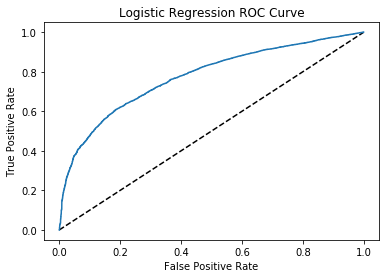

In [14]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)

plt.plot( [0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [15]:
print("AUC: ", roc_auc_score(y_test, lr_pred_prob))

AUC:  0.7748366229513491


## Decision Tree
Parameters to search:
- max_features
- max_depth
- min_samples_leaf

In [16]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import RandomizedSearchCV

In [17]:
criterion_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 20, 50, 75, 100]
min_sample_split_grid = [2, 5, 10, 25, 50, 75, 100]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

dtc_grid = {'criterion': criterion_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [18]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, dtc_grid, cv=5)
tree_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [19]:
print("Best params: " , tree_cv.best_params_)
print("Best score: ", tree_cv.best_score_)

Best params:  {'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 20, 'max_depth': 20, 'criterion': 'entropy'}
Best score:  0.8722944116310767


First run: min_sample_split=2; min_samples_leaf=25; max_features=20, max_depth=20, criterion=entropy

In [24]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=25, 
                                 max_features=20, max_depth=20)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(154.57218255429026, 212.26285714285714, 'X[19] <= 0.13\nentropy = 0.602\nsamples = 55025\nvalue = [8086, 46939]'),
 Text(79.6534175450212, 201.90857142857143, 'X[1] <= -0.307\nentropy = 0.363\nsamples = 31119\nvalue = [2155, 28964]'),
 Text(55.180133818855936, 191.5542857142857, 'X[0] <= 1.652\nentropy = 0.595\nsamples = 11685\nvalue = [1683, 10002]'),
 Text(32.82285746822034, 181.2, 'X[1] <= -0.468\nentropy = 0.562\nsamples = 11501\nvalue = [1515, 9986]'),
 Text(6.945681355932204, 170.84571428571428, 'X[17] <= 2.366\nentropy = 0.936\nsamples = 995\nvalue = [350, 645]'),
 Text(4.44886779661017, 160.49142857142857, 'X[10] <= 0.099\nentropy = 0.974\nsamples = 793\nvalue = [321, 472]'),
 Text(2.3606237288135596, 150.13714285714286, 'X[11] <= -1.102\nentropy = 1.0\nsamples = 472\nvalue = [231, 241]'),
 Text(1.634277966101695, 139.78285714285715, 'X[3] <= -0.005\nentropy = 0.672\nsamples = 51\nvalue = [9, 42]'),
 Text(1.2711050847457628, 129.42857142857144, 'entropy = 0.242\nsamples =

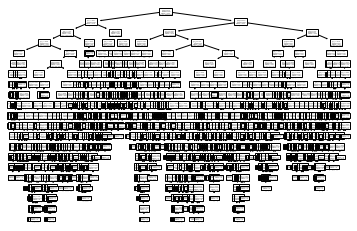

In [26]:
from sklearn.tree import plot_tree
plot_tree(modelDT)

In [32]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

[ True  True False ...  True  True  True]


In [34]:
# Run this block for model evaluation 
from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
#print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = "True"))
#print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = "False"))

Model Metrics
Accuracy: 0.8752067167027096
Balanced accuracy: 0.7052392522783838


In [35]:
print(confusion_matrix(y_test, dt_pred))

[[ 1610  1856]
 [ 1087 19030]]


In [36]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.60      0.46      0.52      3466
        True       0.91      0.95      0.93     20117

    accuracy                           0.88     23583
   macro avg       0.75      0.71      0.73     23583
weighted avg       0.86      0.88      0.87     23583



## Random Forest Classifier

Hyperparameters:
- number of features per tree
- number of trees per forest (n_estimators)
- depth(?)

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
n_tree_grid = [10,50,100,200,250,500]
crit_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 15, 20]
min_sample_split_grid = [2, 5, 10, 20]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

rfc_grid = {'n_estimators':n_tree_grid,
              'criterion': crit_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [52]:
forest = RandomForestClassifier()
start = time.time()
forest_cv = RandomizedSearchCV(forest, rfc_grid, cv=5)
forest_cv.fit(X_train, y)
end = time.time()
print("GridSearch time: ", end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536

GridSearch time:  1833.1879992485046


In [53]:
print("Best params: " , forest_cv.best_params_)
print("Best score: ", forest_cv.best_score_)

Best params:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 15, 'criterion': 'gini'}
Best score:  0.8997183098591549


In [54]:
modelRF = RandomForestClassifier(n_estimators = 200, min_samples_split=2, 
                                 min_samples_leaf=2, max_features=10,
                                max_depth=15, criterion='gini')
modelRF.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
rf_pred = modelRF.predict(X_test)
rf_pred_prob = modelRF.predict_proba(X_test)

In [55]:
print("Random Forest Classifier model")
print("Accuracy:", metrics.accuracy_score(y_test, rf_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rf_pred))
#print('Precision score' , metrics.precision_score(y_test, rf_pred, pos_label = "Yes"))
#print('Recall score' , metrics.recall_score(y_test, rf_pred, pos_label = "No"))

Random Forest Classifier model
Accuracy: 0.9109528049866429
Balanced accuracy: 0.7298932018034946


In [56]:
print(confusion_matrix(y_test, rf_pred))

[[ 1641  1825]
 [  275 19842]]


In [57]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       0.86      0.47      0.61      3466
        True       0.92      0.99      0.95     20117

    accuracy                           0.91     23583
   macro avg       0.89      0.73      0.78     23583
weighted avg       0.91      0.91      0.90     23583



## Random Forest Regression
- n_estimators (default = 100)
- max_depth
- min_samples_split
- min_samples_leaf
- max_features

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
n_tree_grid = [10,50,100,200,250,500]
crit_grid = ['mse', 'mae']
max_depth_grid = ['None', 3, 5, 10, 15, 20]
min_sample_split_grid = [2, 5, 10, 20]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

rfr_grid = {'n_estimators':n_tree_grid,
              'criterion': crit_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [ ]:
forestReg = RandomForestRegressor()
start = time.time()
forestreg_cv = RandomizedSearchCV(forestReg, rfr_grid, cv=5)
forestreg_cv.fit(X_train, y)
end = time.time()
print("GridSearch time: ", end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536

In [ ]:
print("Best params: " , forestreg_cv.best_params_)
print("Best score: ", forestreg_cv.best_score_)

In [ ]:
modelRFR = RandomForestRegressor(n_estimators =_, ...)
modelRFR.fit(X_train, y)

In [ ]:
rfr_pred = modelRFR.predict(X_test)
rfr_pred_prob = modelRFR.predict_proba(X_test)

In [ ]:
print("Random Forest Regression model")
print("Accuracy:", metrics.accuracy_score(y_test, rfr_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rfr_pred))
#print('Precision score' , metrics.precision_score(y_test, rf_pred, pos_label = "Yes"))
#print('Recall score' , metrics.recall_score(y_test, rf_pred, pos_label = "No"))

In [ ]:
print(confusion_matrix(y_test, rfr_pred))

In [ ]:
print(classification_report(y_test, rfr_pred))